# Data Preparation

Data entered by humans or captured from devices are generally (though not always) not in ideal form for machine consumption. Data may not be in appropriate format (not properly encoded), have ranges that are too large (not scaled), be noisy or contain outliers, missing data, may be highly imbalanced, or any number of issues. To build a model, we must first prepare the data, converting it from the messy raw form collected from the system(s) of interest to a format amenable to machine consumption. Here, we will explore the concepts of scaling, imputations, synthetic minority oversampling (SMOTE) and random undersampling. 

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, BayesianRidge
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
RootDir = '\\'.join(os.getcwd().split('\\')[0:-2])
os.chdir(RootDir)

In [3]:
# This notebook contains some common functions that are reused. They are included in one source for clarity.
%run "./notebooks/common/function_library.ipynb"

## Missing Data

Data is often missing in real world data. As a result, there are numerous approaches and techniques developed to handle missing data in real world scenarios. These vary by situation. Data can be missing completely at random, missing at random, or not missing at random. All three rely on assumptions made about the data. Missinge completely at random (MCAR) means that missing data is not dependent upon other variables. An example of this would be a clinician forgets to enter a value some percentage of the time, or forgets to attach leads from a vital sign. Missing at random refers to the instance where missing data can be explained by other data distributions. For example, missing blood pressure explained by age/weight. A clinician may decide that taking blood pressure is not necessary for patients depending on their age/weight. 

For further explanation see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4121561/

In [4]:
# Read the data using pandas
input_df = pd.read_csv('data/tabular_data.csv')
input_df['total_rx'] = input_df['total_rx'].fillna(0)
input_df['abnormal_lab_fraction'] = input_df['abnormal_lab_fraction'].fillna(0)
input_df['micro_organism'] = input_df['micro_organism'].fillna(2)
input_df

,gender,admission_type,insurance,ethnicity,diagnosis,total_rx,total_dx,los,abnormal_lab_fraction,micro_organism,icd9_code_V053,icd9_code_V290,icd9_code_7742,icd9_code_769,readmit_flag
0,M,NEWBORN,Private,ASIAN,NEWBORN,2.0,3,0.0918,0.340426,0.0,1,1,0,0,0
1,M,NEWBORN,Private,ASIAN,NEWBORN,0.0,3,0.0844,0.263158,0.0,1,1,0,0,0
2,F,NEWBORN,Private,WHITE,NEWBORN,0.0,3,0.2677,0.357143,0.0,1,1,0,0,1
3,F,NEWBORN,Private,WHITE,NEWBORN,0.0,3,0.7391,0.357143,0.0,1,1,0,0,0
4,M,NEWBORN,Private,WHITE,NEWBORN,2.0,6,1.0755,0.400000,0.0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,M,NEWBORN,Private,WHITE,NEWBORN,0.0,1,0.2158,0.400000,0.0,0,0,0,0,0
8096,M,NEWBORN,Private,WHITE,NEWBORN,2.0,4,0.3103,0.277778,0.0,0,0,0,0,0
8097,F,NEWBORN,Private,WHITE,NEWBORN,0.0,3,0.1894,0.250000,0.0,1,1,0,0,0
8098,F,NEWBORN,Private,WHITE,NEWBORN,43.0,23,138.9928,0.367747,1.0,1,1,1,1,0


## Test/Holdout Set

The purpose of building a model is to use a model in real-life (i.e. deploy it). We cannot judge performance based solely on the data used to build (train) our model, but need to test it on data that the model has not been exposed to. The ability for a model to perform well on data it has not seen is called generalizability. To test this, we can split the data into a training and test (sometimes called the holdout) sets. Thus, a model is built using the train dataset and final evaluation occurs on the test/holdout set. To prevent a phenomenon known as data leakage, it is imperative that we remove the data prior to performing any data preparation steps. Here, we use the built in train_test_split function in scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Because of the class imbalance, we stratify the train/test split by the target feature to assure that we have equal fractions for both datasets. 

In [5]:
train_df, test_df = train_test_split(input_df,test_size=0.3,random_state=42, stratify=input_df['readmit_flag'].tolist())

In [6]:
type_dict = {
    'readmit_flag':'int',
    'total_rx_minmax':'int', 
    'total_dx_minmax':'int', 
    'los_scaled':'float', 
    'abnormal_lab_fraction':'float',
    'micro_organism':'int', 
    'icd9_code_V053':'int', 
    'icd9_code_V290':'int', 
    'icd9_code_7742':'int',
    'icd9_code_769':'int', 
    'admission_type_encode':'int',
    'insurance_encode':'int', 
    'ethnicity_encode':'int', 
    'diagnosis_encode':'int'
    }

## Data Encoding

Now we need to convert data to a machine readable format. We have four kinds of transformations, 1) LabelEncoder, 2) MinMaxScaler, 3) StandardScaler, 4) StrBinarizer.

#### Label Encoder

Maps categorical data to integer values. This is useful when the data is categorical, but not ordered (ordinal). As an example, large, medium, and small are ordinal, in that we know large > medium > small, however the magnitude of difference is not known. For ordinal data, the OrdinalEncoder can be used. 

#### MinMaxScaler

Normalizes the data to the range of [0, 1]. This is best used when the data is roughly uniform or the values are integers.

#### StandardScaler

Standardizes the data, centering the distribution to a mean of 0 and standard deviation of 1. This is best used when the data is roughly normal. 

#### StrBinarizer

This is a custom build function, which binarizes strings (encodes them to either 0 or 1). Here, the target_label -> 1, while the remaining values are converted to 0. Binarizers are useful when one class of the data comprises roughly 50% of the samples, and the remaining classes contain several other samples. 

For more on preprocessing, see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

In [7]:
train_df = StrBinarize(input_df=train_df, target_col='admission_type', target_label='NEWBORN')
train_df = StrBinarize(input_df=train_df, target_col='insurance', target_label='Private')
train_df = StrBinarize(input_df=train_df, target_col='ethnicity', target_label='WHITE')
train_df = StrBinarize(input_df=train_df, target_col='diagnosis', target_label='NEWBORN')

label_encoder = LabelEncoder()
label_encoder.fit(train_df['gender'])
train_df['gender_encode'] = label_encoder.transform(train_df['gender'])

mx_0 = MinMaxScaler()
mx_0.fit(train_df['total_rx'].values.reshape(-1,1))
train_df['total_rx_minmax'] = mx_0.transform(train_df['total_rx'].values.reshape(-1,1))

mx_1 = MinMaxScaler()
mx_1.fit(train_df['total_dx'].values.reshape(-1,1))
train_df['total_dx_minmax'] = mx_1.transform(train_df['total_dx'].values.reshape(-1,1))

sc = StandardScaler()
sc.fit(train_df['los'].values.reshape(-1,1))
train_df['los_scaled'] = sc.transform(train_df['los'].values.reshape(-1,1))

train_df = train_df[list(type_dict.keys())]
train_df = train_df.astype(type_dict)
train_df.reset_index(inplace=True, drop=True)

To prevent data leakage, we fit the encoding models on the training data, and then transform training and test data. 

In [8]:
test_df = StrBinarize(input_df=test_df, target_col='admission_type', target_label='NEWBORN')
test_df = StrBinarize(input_df=test_df, target_col='insurance', target_label='Private')
test_df = StrBinarize(input_df=test_df, target_col='ethnicity', target_label='WHITE')
test_df = StrBinarize(input_df=test_df, target_col='diagnosis', target_label='NEWBORN')

test_df['gender_encode'] = label_encoder.transform(test_df['gender'])
test_df['total_rx_minmax'] = mx_0.transform(test_df['total_rx'].values.reshape(-1,1))
test_df['total_dx_minmax'] = mx_1.transform(test_df['total_dx'].values.reshape(-1,1))
test_df['los_scaled'] = sc.transform(test_df['los'].values.reshape(-1,1))

test_df = test_df[list(type_dict.keys())]
test_df = test_df.astype(type_dict)
test_df.reset_index(inplace=True, drop=True)

In [9]:
# Check for missingness in the training data.
train_df.isnull().sum()

readmit_flag             0
total_rx_minmax          0
total_dx_minmax          0
los_scaled               5
abnormal_lab_fraction    0
micro_organism           0
icd9_code_V053           0
icd9_code_V290           0
icd9_code_7742           0
icd9_code_769            0
admission_type_encode    0
insurance_encode         0
ethnicity_encode         0
diagnosis_encode         0
dtype: int64

In [10]:
# Check for missingness in the test data.
test_df.isnull().sum()

readmit_flag             0
total_rx_minmax          0
total_dx_minmax          0
los_scaled               2
abnormal_lab_fraction    0
micro_organism           0
icd9_code_V053           0
icd9_code_V290           0
icd9_code_7742           0
icd9_code_769            0
admission_type_encode    0
insurance_encode         0
ethnicity_encode         0
diagnosis_encode         0
dtype: int64

In [11]:
train_features = train_df.columns[1:]

## Data Imputation

Almost all real-world has missingness, resulting in the need for strategies to handle this data. Imputation strategies... Multiple approaches exist to handle missingness in data. Some of these are:

### Deletion of Data

Perhaps the simplest approach to handling missing data is to simply delete entries that are msising. This prevents the introduction of spurious correlations between variables and reduces the chance of adding unrealistic values/value combinations. This is most feasible when a large quantity of data has been collected. For instance, consider a training set containing 200,000 entries with 10% of the rows containing missing data in some form. Removal of 20,000 entries leaves us with 180,000 remaining data points for training, more than sufficient for most machine learning applications. 

### Univariate Imputation

Univariate imputation uses only information in the feature to deduce missing values, while ignoring information present within other features. Examples of this include replacement of missing values with a summary statistics, such as the mean or median. This approach is often overly simplistic and generally does not yield the most accurate replacement values. However, depending on the application, these may be more feasible options. For example, a real-time application may prioritize speed over quality of imputed data.

### Multivariate Imputation

Multivariate imputations models missing values as a function of other features, generally resulting in more sophisticated imputed values. The most popular of these approaches (and the generally recommended approach) is multiple imputation with chained equations (MICE). Briefly, MICE models missing values in a feature as a function of all other features. A predictive model for each feature is built and the missing values imputed. This is performed N times to create N-different datasets, all with different imputed values. Training then occurs over these datasets to provide an estimate of the error introduced through imputation.   

For more see https://scikit-learn.org/stable/modules/impute.html#impute and https://www.jstatsoft.org/article/view/v045i03

In [12]:
# impute the training data
data_imputer = DataImputer()
data_imputer.set_state(
    cat_estimator=LogisticRegression(),
    num_estimator=BayesianRidge(),
    input_df=train_df[train_features])

data_imputer.map_features()
data_imputer.impute_data()

train_impute, _, _ = data_imputer.get_state()

In [13]:
# Now impute the test set with the saved models
data_imputer.set_state(
    cat_estimator=LogisticRegression(),
    num_estimator=BayesianRidge(),
    input_df=test_df[train_features])

data_imputer.map_features()
data_imputer.impute_data()


test_impute, _, _ = data_imputer.get_state()

In [14]:
train_impute.insert(0,'readmit_flag',train_df['readmit_flag'])
test_impute.insert(0,'readmit_flag',test_df['readmit_flag'])

In [15]:
train_impute.to_csv('data/train_impute.csv',index=False)
test_impute.to_csv('data/test_impute.csv',index=False)

In [16]:
train_features = train_impute.columns[1:]
target_feature = 'readmit_flag'

# Get X/y
X_train = train_impute[train_features]
y_train = train_impute[target_feature]

## Class Imbalance - A Tale of Two Approaches

Class imbalance refers to the presence of a disproportionate number of samples in one class versus another. While there is no hard and fast rule for what constitutes class imbalance, generally a 10:1 majority:minority ratio or greater requires some kind of additional treatment. This poses challenges to training, as the model weights for the minority class are updated less frequently than for the majority class. This effectively results in the model "learning" the majority class much better than the minority. Class imbalance is common throughout numerous machine learning tasks. This is especially true for healthcare, which often has far more samples in one class (generally the class which is not of primary interest) as opposed to another class (which is normally the one of interest). Two primary approaches exist to solving this issue. The first is to weight the minority class contributions more heavily than the majority. In effect, parameters are updated more for each minority class than for majority. The second approach is to change the composition of the training sample using synthetic data generation and undersampling. 

### Synthetic Minority Oversampling Technique

Affectionaly known as SMOTE, this technique is used to reduce the effects of class imbalance by generating synthetic data entries using data that is close in space to existing values. Technically, k-nearest neighbors are used to estimate the values for the new data. This can colloquially be described as "filling in the blanks" or interpolating existing data. Before and after examples are shown below outlining the effects of SMOTE. In addition to SMOTE, undersampling is recommended to improve performance. Thus, synthetic data is used to boost the minority class and a percentage of the majority class is randomly removed. 

#### Binary classification data before SMOTE
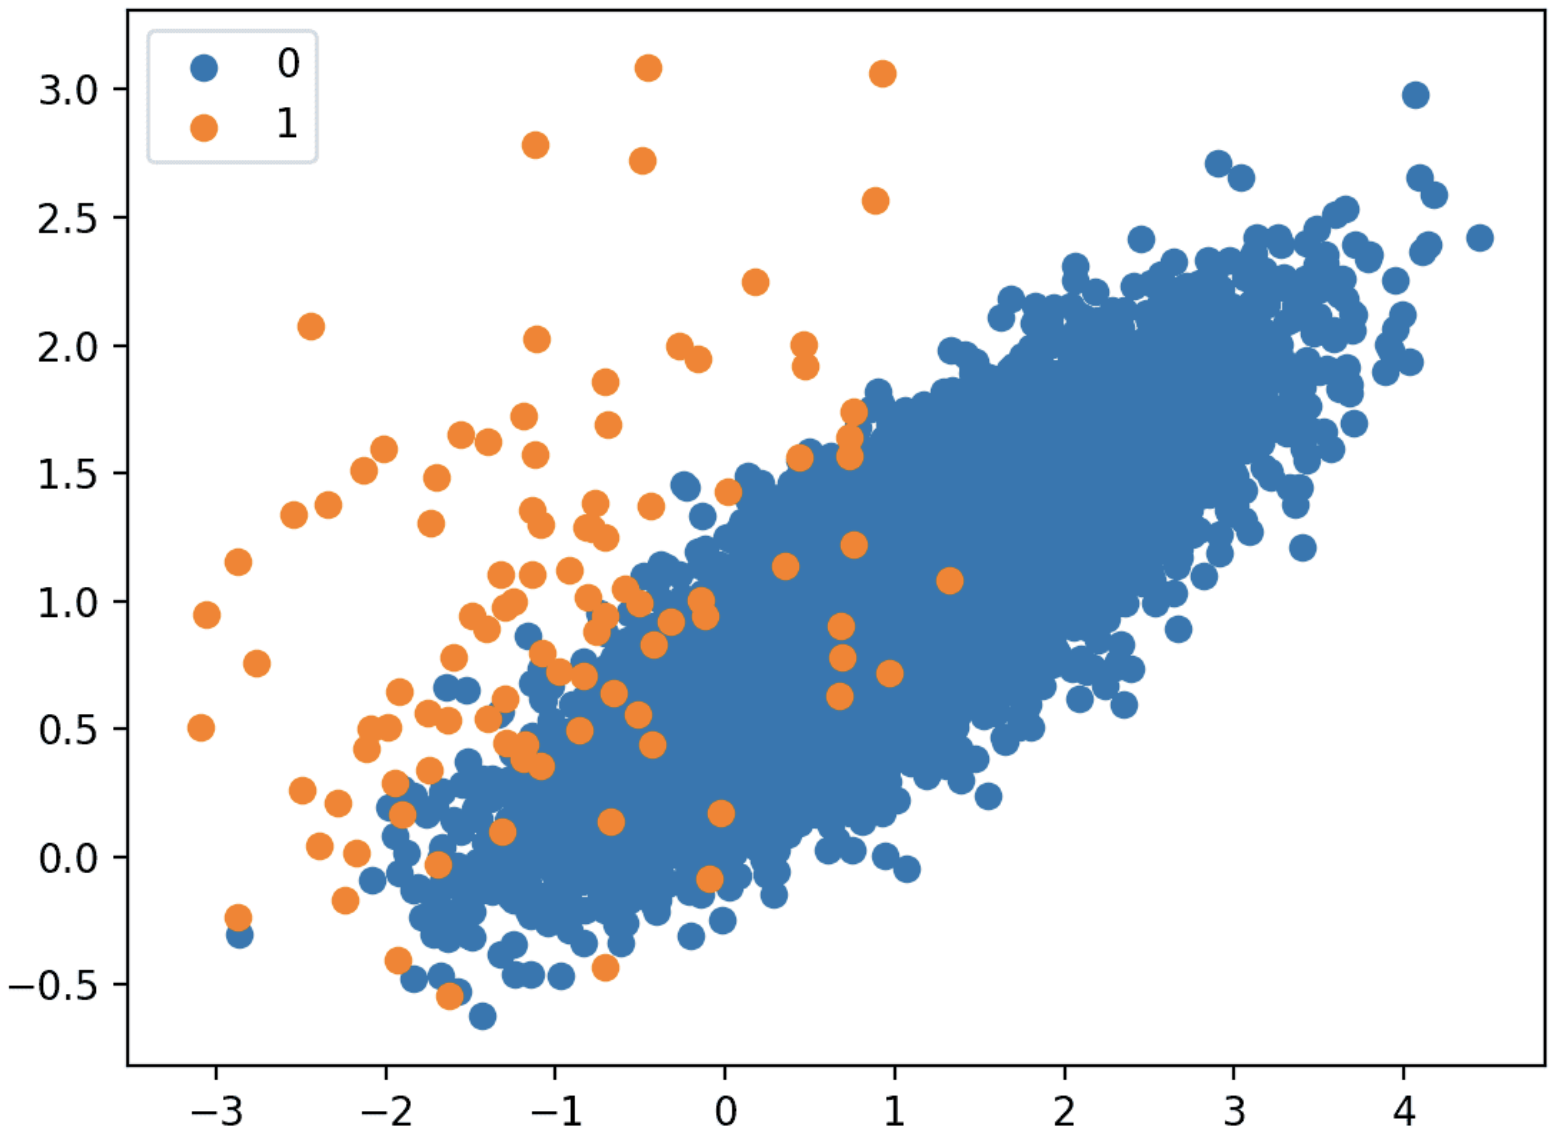

#### Binary classification data after SMOTE
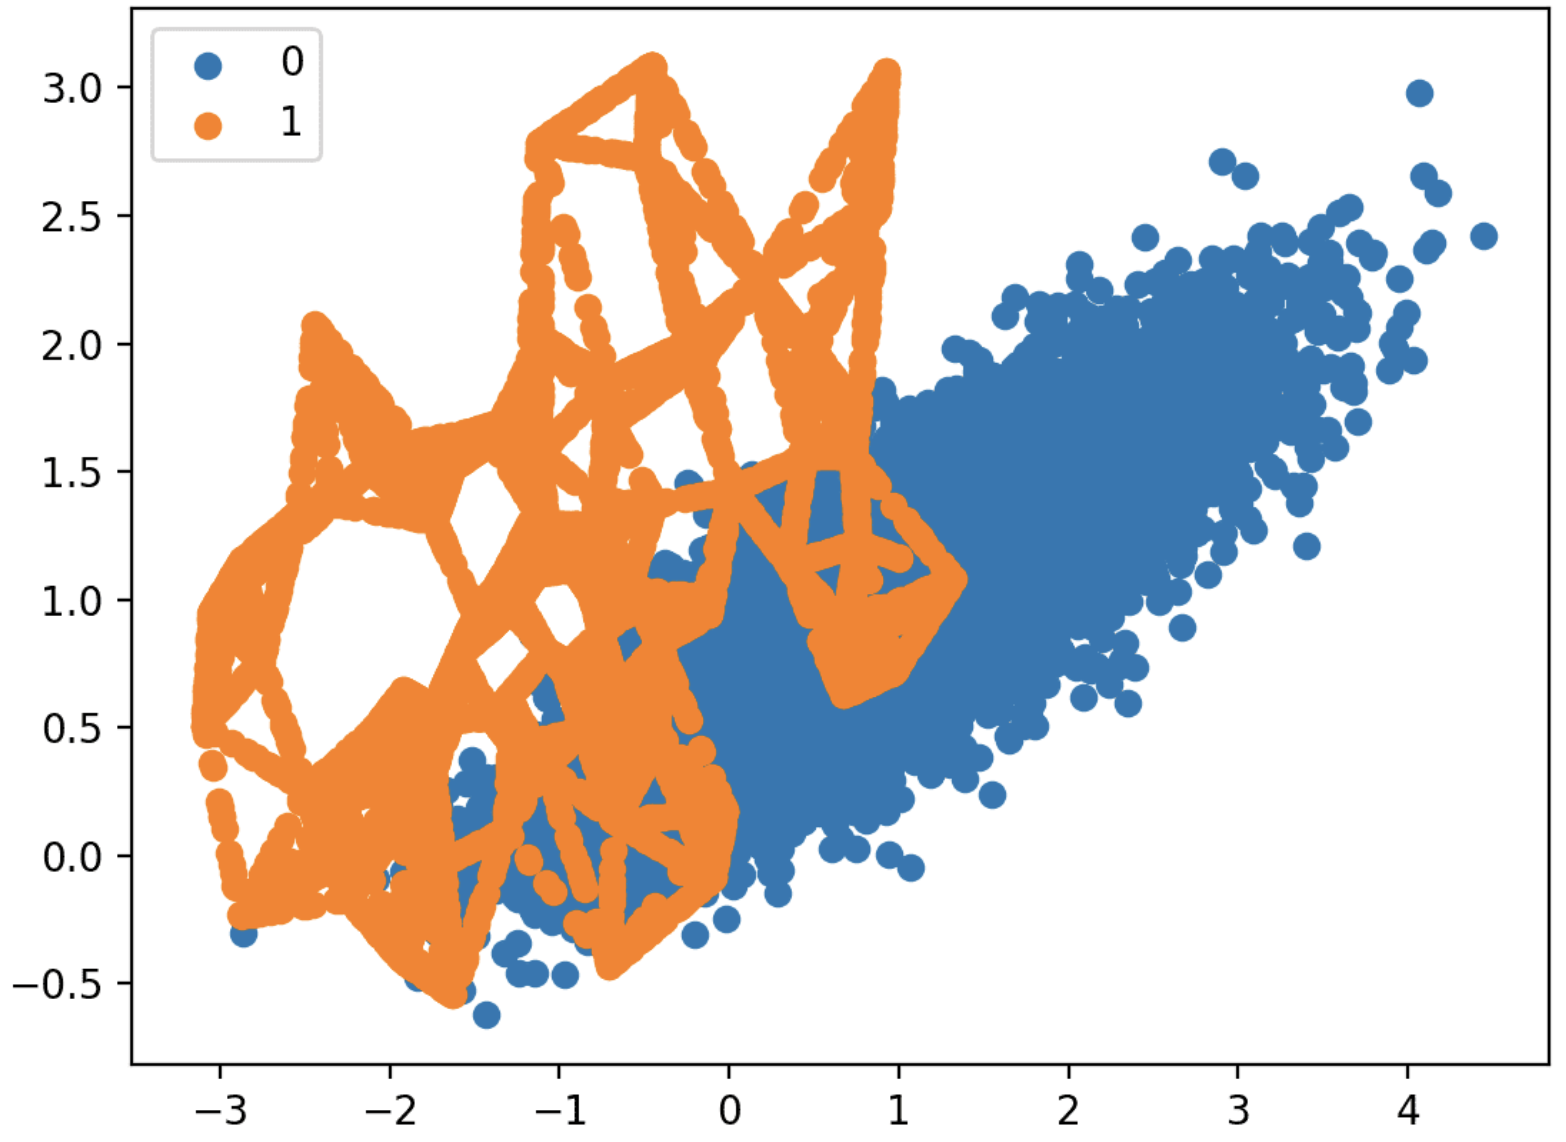

See also https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html and https://dl.acm.org/doi/10.5555/1622407.1622416

In [17]:
oversample = SMOTE(sampling_strategy=0.1)
undersample = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)
X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)

In [18]:
train_smote = X_train_smote
train_smote.insert(0, 'readmit_flag', y_train_smote)

In [19]:
train_smote.to_csv('data/train_smote.csv',index=False)

In [20]:
train_smote

,readmit_flag,total_rx_minmax,total_dx_minmax,los_scaled,abnormal_lab_fraction,micro_organism,icd9_code_V053,icd9_code_V290,icd9_code_7742,icd9_code_769,admission_type_encode,insurance_encode,ethnicity_encode,diagnosis_encode
5050,0,0.0,0.0,-0.473969,0.266667,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5512,0,0.0,0.0,3.757733,0.104846,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3957,0,0.0,0.0,-0.568895,0.300000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4418,0,0.0,0.0,-0.393601,0.193548,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2704,0,0.0,0.0,-0.473487,0.206897,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6086,1,0.0,0.0,-0.470897,0.361629,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6087,1,0.0,0.0,-0.468227,0.283961,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6088,1,0.0,0.0,-0.471753,0.216431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6089,1,0.0,0.0,-0.468603,0.263031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
